# Walmart_Sales_Prediction_BH2

You are provided with historical sales data for 45 Walmart stores located in different regions. Each store contains a number of departments, and you are tasked with predicting the department-wide sales for each store.



To solve this problem we follow these steps:
1.  Download and Explore the dataset.
2.  Exploratory data Analysis.
3.  Data Preprocessing.
4.  Prepare the Data for Training.
5.  Fit the different model, tuning it and choose the best nodel for test data.
6.  Final selection the model and prediction.
7.  Saving and Loading trained model
8.  Summary and References

In [1]:
!pip install jovian --upgrade --quiet

     |████████████████████████████████| 68 kB 3.1 MB/s 


In [2]:
import jovian

## Download and Explore the Data

In [3]:
!pip install opendatasets --quiet

In [4]:
# impot the important libraries.
import opendatasets as od
import os 


In [5]:
# Download the dataset 
od.download('https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting')

Skipping, found downloaded files in "./walmart-recruiting-store-sales-forecasting" (use force=True to force download)


In [6]:
os.listdir('walmart-recruiting-store-sales-forecasting')

['stores.csv',
 'test.csv.zip',
 'features.csv.zip',
 'train.csv.zip',
 'sampleSubmission.csv.zip']

In [7]:
# import the useful libraties
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline 



In [8]:
train_df=pd.read_csv('walmart-recruiting-store-sales-forecasting/train.csv.zip',low_memory = False)
sample_submission=pd.read_csv('walmart-recruiting-store-sales-forecasting/sampleSubmission.csv.zip')
features_df=pd.read_csv('walmart-recruiting-store-sales-forecasting/features.csv.zip')
stores_df=pd.read_csv('walmart-recruiting-store-sales-forecasting/stores.csv')
test_df=pd.read_csv('walmart-recruiting-store-sales-forecasting/test.csv.zip')

In [7]:
train_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [8]:
sample_submission.head()

,Id,Weekly_Sales
0,1_1_2012-11-02,0
1,1_1_2012-11-09,0
2,1_1_2012-11-16,0
3,1_1_2012-11-23,0
4,1_1_2012-11-30,0


In [9]:
features_df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [10]:
stores_df.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [11]:
test_df.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [9]:
# merge the stores and features dataframes on store
store_features_df = stores_df.merge(features_df,how = 'left',on = 'Store')

In [10]:
# merge the stores_features dataframe to train and test sepretly on Store,Date and IsHoliday 
train_df = train_df.merge(store_features_df, how= 'left',left_on = ['Store','Date','IsHoliday'],right_on = ['Store','Date','IsHoliday'])
test_df = test_df.merge(store_features_df, how= 'left',left_on = ['Store','Date','IsHoliday'],right_on = ['Store','Date','IsHoliday'])

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Type          421570 non-null  object 
 6   Size          421570 non-null  int64  
 7   Temperature   421570 non-null  float64
 8   Fuel_Price    421570 non-null  float64
 9   MarkDown1     150681 non-null  float64
 10  MarkDown2     111248 non-null  float64
 11  MarkDown3     137091 non-null  float64
 12  MarkDown4     134967 non-null  float64
 13  MarkDown5     151432 non-null  float64
 14  CPI           421570 non-null  float64
 15  Unemployment  421570 non-null  float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.9+ MB



- Null values occured only in the Markdown1-5 columns  

### Modification of Date
- Split the Date column to Day, Year, Month & Week

In [11]:
# split the date into Day,Year and Month
def split_date(df):
    df['Date']= pd.to_datetime(df['Date'])
    df['Year']= df.Date.dt.year
    df['month']= df.Date.dt.month
    df['Day']=df.Date.dt.day
    df['Week']= df.Date.dt.isocalendar().week

In [12]:
split_date(train_df)
split_date(test_df)

In [19]:
train_df.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,month,Day,Week
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,2010,2,5,5
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,2010,2,12,6
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,2010,2,19,7
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,2010,2,26,8
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,2010,3,5,9


In [20]:
test_df.head(5)

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,month,Day,Week
0,1,1,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,2012,11,2,44
1,1,1,2012-11-09,False,A,151315,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,2012,11,9,45
2,1,1,2012-11-16,False,A,151315,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,2012,11,16,46
3,1,1,2012-11-23,True,A,151315,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,2012,11,23,47
4,1,1,2012-11-30,False,A,151315,52.34,3.207,2460.03,NaN,3838.35,150.57,6966.34,223.610984,6.573,2012,11,30,48


## Exploratory Data Analysis

In [13]:
# import the important libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set_style('darkgrid')
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


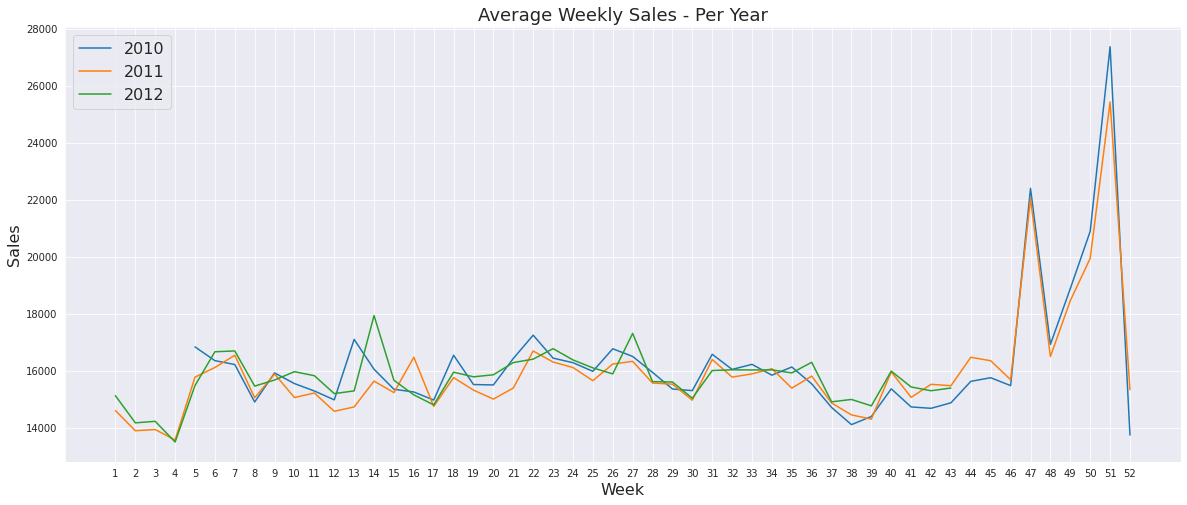

In [22]:
weekly_sales_2010 = train_df[train_df.Year==2010]['Weekly_Sales'].groupby(train_df['Week']).mean()
weekly_sales_2011 = train_df[train_df.Year==2011]['Weekly_Sales'].groupby(train_df['Week']).mean()
weekly_sales_2012 = train_df[train_df.Year==2012]['Weekly_Sales'].groupby(train_df['Week']).mean()
plt.figure(figsize=(20,8));
sns.lineplot(weekly_sales_2010.index, weekly_sales_2010.values);
sns.lineplot(weekly_sales_2011.index, weekly_sales_2011.values);
sns.lineplot(weekly_sales_2012.index, weekly_sales_2012.values);
plt.xticks(np.arange(1, 53, step=1));
plt.legend(['2010', '2011', '2012'], loc='best', fontsize=16);
plt.title('Average Weekly Sales - Per Year', fontsize=18);
plt.ylabel('Sales', fontsize=16);
plt.xlabel('Week', fontsize=16);
plt.show();

Useful insight
- weekly sales are strongly related with the week.
- Every year, the no_of_week have the almost same relation with the sales.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


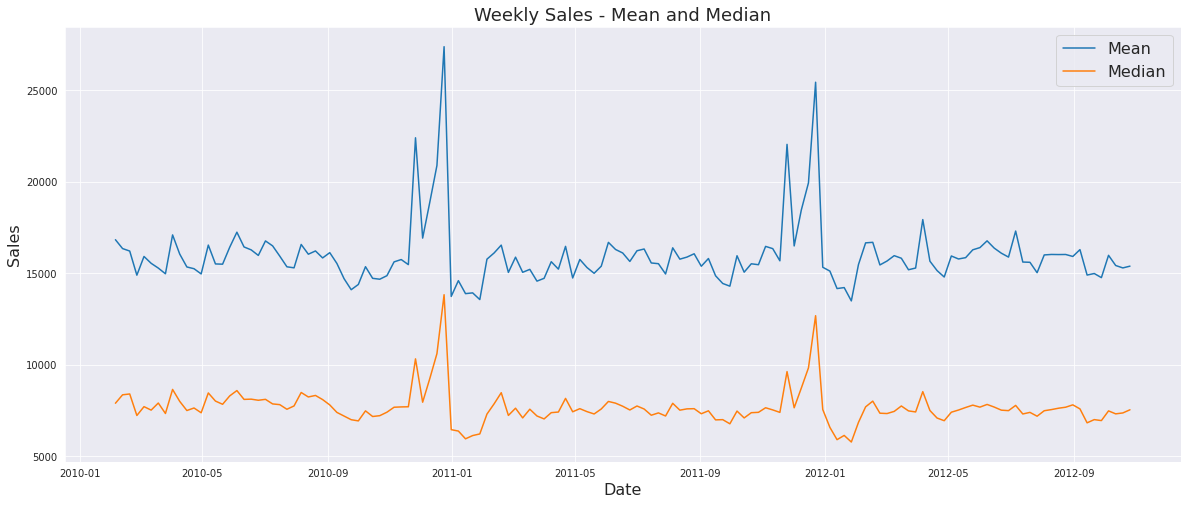

In [23]:
# draw the line chart of mean of weekly_sales according to the weeks.
weekly_sales_mean = train_df['Weekly_Sales'].groupby(train_df['Date']).mean()
weekly_sales_median = train_df['Weekly_Sales'].groupby(train_df['Date']).median()
plt.figure(figsize=(20,8))
sns.lineplot(weekly_sales_mean.index, weekly_sales_mean.values)
sns.lineplot(weekly_sales_median.index, weekly_sales_median.values)
plt.legend(['Mean', 'Median'], loc='best', fontsize=16)
plt.title('Weekly Sales - Mean and Median', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.show()

Useful insight

- mean(weekly sales) is greater than the median(weekly sales).
- Most of the data lie in left side of the mean. as data is left skewed.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


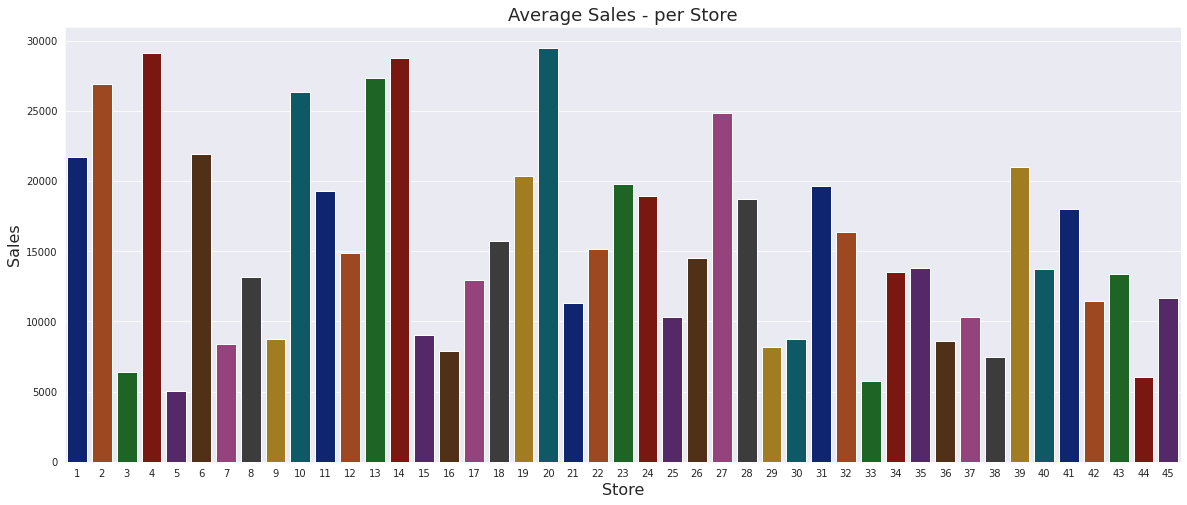

In [24]:
# draw the total sales according to the stores.
weekly_sales = train_df['Weekly_Sales'].groupby(train_df['Store']).mean()
plt.figure(figsize=(20,8))
sns.barplot(weekly_sales.index, weekly_sales.values, palette='dark')
plt.title('Average Sales - per Store', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


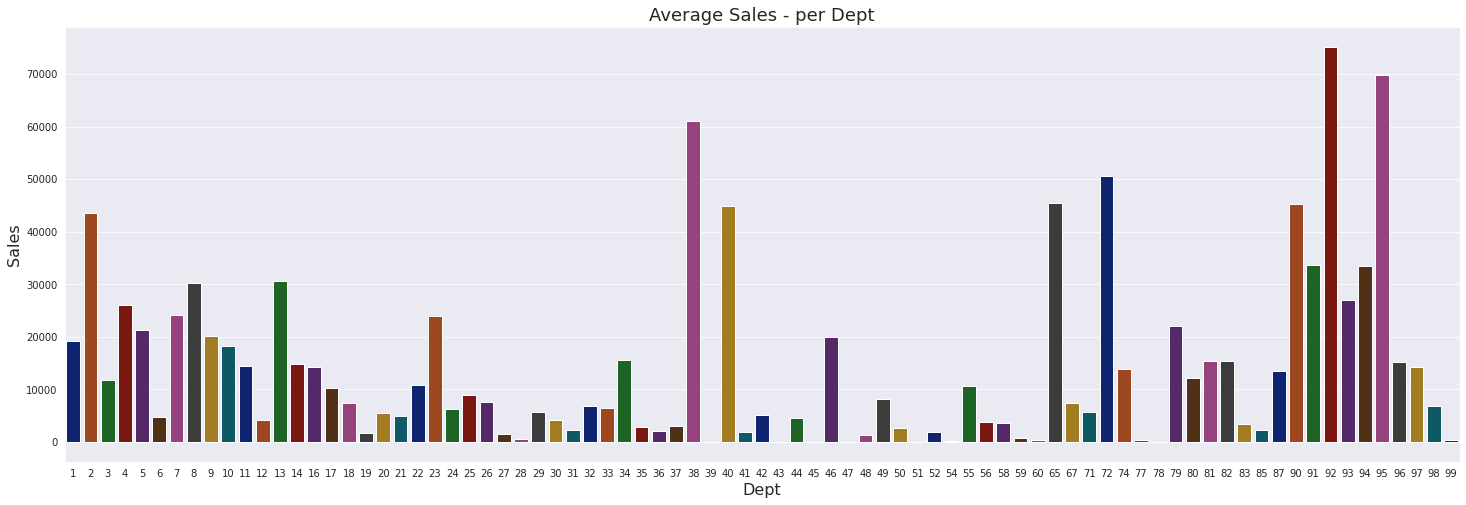

In [25]:
# draw the total sales according to the department.
weekly_sales = train_df['Weekly_Sales'].groupby(train_df['Dept']).mean()
plt.figure(figsize=(25,8))
sns.barplot(weekly_sales.index, weekly_sales.values, palette='dark')
# plt.grid()
plt.title('Average Sales - per Dept', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Dept', fontsize=16)
plt.show()

Useful insight

- sales is different according to the different stores.
- Sales is also different according to the different Departments.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


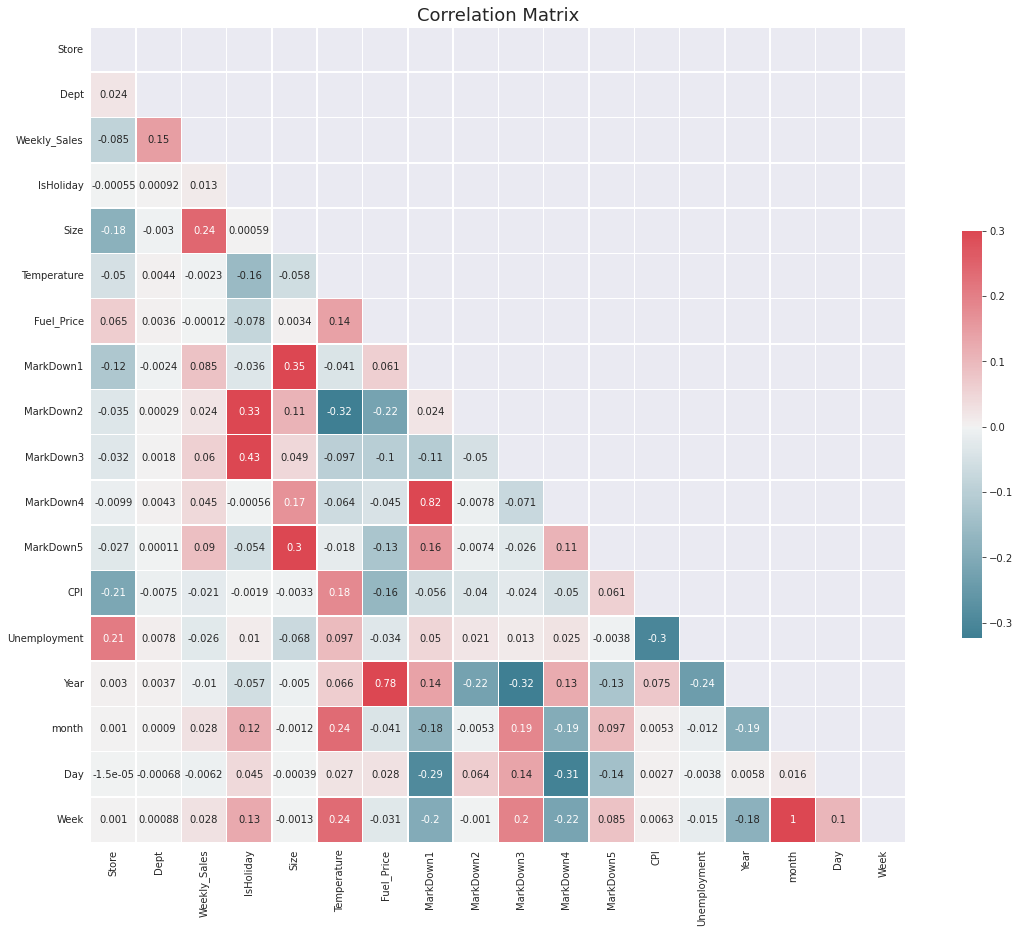

In [26]:
# Draw the heatmap of correlation.

corr = train_df.corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(20, 15))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.title('Correlation Matrix', fontsize=18)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

- Correlation Heatmap is given above 

## Data Preprocessing
- Imputting Missing Markdown1-5 values to Zero.
- Removing the data with the negative weekly_sales.
- Modify the IsHoliday column to 1 and 0.

In [14]:
# imputing missing Markdown1-5 values 
def markdown_imputation(final_data):    
    final_data.loc[final_data.MarkDown1.isnull() ,'MarkDown1']= 0
    final_data.loc[final_data.MarkDown2.isnull() ,'MarkDown2']= 0
    final_data.loc[final_data.MarkDown3.isnull() ,'MarkDown3']= 0
    final_data.loc[final_data.MarkDown4.isnull() ,'MarkDown4']= 0
    final_data.loc[final_data.MarkDown5.isnull() ,'MarkDown5']= 0
    return final_data

In [15]:
markdown_imputation(train_df)
markdown_imputation(test_df)

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,month,Day,Week
0,1,1,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,2012,11,2,44
1,1,1,2012-11-09,False,A,151315,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,2012,11,9,45
2,1,1,2012-11-16,False,A,151315,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,2012,11,16,46
3,1,1,2012-11-23,True,A,151315,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,2012,11,23,47
4,1,1,2012-11-30,False,A,151315,52.34,3.207,2460.03,0.00,3838.35,150.57,6966.34,223.610984,6.573,2012,11,30,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115059,45,98,2013-06-28,False,B,118221,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,2013,6,28,26
115060,45,98,2013-07-05,False,B,118221,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,2013,7,5,27
115061,45,98,2013-07-12,False,B,118221,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,2013,7,12,28
115062,45,98,2013-07-19,False,B,118221,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,2013,7,19,29


In [16]:
# Removing the data with negative Weekly_Sales
def weekly_sales_imputation(final_data):    
    final_data[final_data.Weekly_Sales<0]
    print('before removing negative weekly sales ,shape of final dataframe is :',final_data.shape)
    final_data=final_data[final_data.Weekly_Sales>=0]
    print('after removing negative weekly sales ,shape of final dataframe is :',final_data.shape)
    return final_data

In [17]:
weekly_sales_imputation(train_df)


before removing negative weekly sales ,shape of final dataframe is : (421570, 20)
after removing negative weekly sales ,shape of final dataframe is : (420285, 20)


,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,month,Day,Week
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,0.00,0.00,0.00,0.00,0.00,211.096358,8.106,2010,2,5,5
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,0.00,0.00,0.00,0.00,0.00,211.242170,8.106,2010,2,12,6
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,0.00,0.00,0.00,0.00,0.00,211.289143,8.106,2010,2,19,7
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,0.00,0.00,0.00,0.00,0.00,211.319643,8.106,2010,2,26,8
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,0.00,0.00,0.00,0.00,0.00,211.350143,8.106,2010,3,5,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,B,118221,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,2012,9,28,39
421566,45,98,2012-10-05,628.10,False,B,118221,64.89,3.985,5046.74,0.00,18.82,2253.43,2340.01,192.170412,8.667,2012,10,5,40
421567,45,98,2012-10-12,1061.02,False,B,118221,54.47,4.000,1956.28,0.00,7.89,599.32,3990.54,192.327265,8.667,2012,10,12,41
421568,45,98,2012-10-19,760.01,False,B,118221,56.47,3.969,2004.02,0.00,3.18,437.73,1537.49,192.330854,8.667,2012,10,19,42


In [18]:
# Modify the IsHoliday column to 1 and 0.
def holiday_label(final_data):
    final_data.loc[(final_data.IsHoliday==True) ,'IsHoliday']= 1
    final_data.loc[(final_data.IsHoliday==False) ,'IsHoliday']= 0
    return final_data

In [19]:
holiday_label(train_df)
holiday_label(test_df)


,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,month,Day,Week
0,1,1,2012-11-02,0,A,151315,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,2012,11,2,44
1,1,1,2012-11-09,0,A,151315,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,2012,11,9,45
2,1,1,2012-11-16,0,A,151315,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,2012,11,16,46
3,1,1,2012-11-23,1,A,151315,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,2012,11,23,47
4,1,1,2012-11-30,0,A,151315,52.34,3.207,2460.03,0.00,3838.35,150.57,6966.34,223.610984,6.573,2012,11,30,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115059,45,98,2013-06-28,0,B,118221,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,2013,6,28,26
115060,45,98,2013-07-05,0,B,118221,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,2013,7,5,27
115061,45,98,2013-07-12,0,B,118221,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,2013,7,12,28
115062,45,98,2013-07-19,0,B,118221,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,2013,7,19,29


In [33]:
train_df.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,month,Day,Week
0,1,1,2010-02-05,24924.50,0,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,2010,2,5,5
1,1,1,2010-02-12,46039.49,1,A,151315,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,2010,2,12,6
2,1,1,2010-02-19,41595.55,0,A,151315,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,2010,2,19,7
3,1,1,2010-02-26,19403.54,0,A,151315,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,2010,2,26,8
4,1,1,2010-03-05,21827.90,0,A,151315,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,2010,3,5,9


In [34]:
test_df.head(5)

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,month,Day,Week
0,1,1,2012-11-02,0,A,151315,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,2012,11,2,44
1,1,1,2012-11-09,0,A,151315,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,2012,11,9,45
2,1,1,2012-11-16,0,A,151315,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,2012,11,16,46
3,1,1,2012-11-23,1,A,151315,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,2012,11,23,47
4,1,1,2012-11-30,0,A,151315,52.34,3.207,2460.03,0.00,3838.35,150.57,6966.34,223.610984,6.573,2012,11,30,48


## Preparing the data for Training
- split the data into train and validation dataset.
- define the input and target columns.
- Identify the numeric and calegorical columns. 
- Apply Scaling to the numeric columns.
- Apply Encoding to the categorical columns.

###  Split the dataset into Train and Validation dataset

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
trainX_df,val_df = train_test_split(train_df,test_size=0.3,random_state=42)


In [22]:
print('trainX_df.shape : ', trainX_df.shape)
print('val_df.shape : ', val_df.shape)

trainX_df.shape :  (295099, 20)
val_df.shape :  (126471, 20)


### Identifying input and target columns

In [23]:
input_cols = ['Store', 'Dept', 'IsHoliday', 'Type', 'Size','Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3','MarkDown4', 'MarkDown5', 'CPI', 'Unemployment','Week']
target_cols = ['Weekly_Sales']

In [24]:
train_inputs = trainX_df[input_cols].copy()
train_targets = trainX_df[target_cols].copy()

In [25]:
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_cols].copy()

### Numeric and categorical columns

In [26]:
# numeric_cols = train_df.select_dtypes(include = np.number).columns.tolist()
# categorical_cols = train_df.select_dtypes('object').columns.tolist()

# Here we manually select the numeric and categorical columns
numeric_cols =  ['Size','Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3','MarkDown4', 'MarkDown5', 'CPI', 'Unemployment']
categorical_cols =  ['Store', 'Dept', 'IsHoliday', 'Type','Week']

### Scaling the Numeric features

In [27]:
from sklearn.preprocessing import MinMaxScaler

In [28]:
# Scaling the Numeric columns 
scaler = MinMaxScaler()
scaler.fit(train_df[numeric_cols])



MinMaxScaler()

In [29]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])

### Encode the Categorical features

In [30]:
from sklearn.preprocessing import OneHotEncoder

# Encoding the categorical columns
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoder.fit(train_df[categorical_cols])
encoded_cols = list(encoder.get_feature_names(categorical_cols))


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [31]:
len(encoded_cols)

183

In [32]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


In [33]:
# combined the columns for model fitting
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]

In [49]:
X_train.shape

(295099, 193)

In [50]:
X_val.shape

(126471, 193)

## Fit the different model and choose Best fit
- fit the Random forest model, tuning and find the error for validation data.
- fit the Gredient boosting model, tuning and find the error for validation data.
- comparison both model and choose best model.

## Fit the Random Forest model

In [34]:
from sklearn.ensemble import RandomForestRegressor 

In [52]:
regressor = RandomForestRegressor(n_estimators=20,n_jobs=-1,random_state=42)


In [53]:
%%time 
regressor.fit(X_train,train_targets)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


CPU times: user 9min 23s, sys: 1.95 s, total: 9min 25s
Wall time: 4min 52s


RandomForestRegressor(n_estimators=20, n_jobs=-1, random_state=42)

In [54]:
preds = regressor.predict(X_train)

In [55]:
preds

array([ 10738.1025,  11681.723 , 111626.074 , ...,  10622.1765,
         5021.7895,   8430.799 ])

In [35]:
# find the root mean error
from sklearn.metrics import mean_squared_error

def rmse(a, b):
    return mean_squared_error(a, b, squared=False)

In [57]:
rmse(preds, train_targets)

1537.5602746780164

In [58]:
val_preds = regressor.predict(X_val)
val_preds

array([47416.409 ,  3219.708 , 10439.76  , ..., 52108.454 ,   651.5485,
        4752.8065])

In [59]:
rmse(val_preds,val_targets)

4067.640465875536

In [60]:
regressor.estimators_[0]

DecisionTreeRegressor(max_features='auto', random_state=1608637542)

In [61]:
# install libraty for vistalizing the tree
from sklearn.tree import plot_tree

In [62]:
len(regressor.estimators_)

20

In [63]:
# find the most important features in the model
importance_df = pd.DataFrame({
    'Features' : X_train.columns,
    'importance' : regressor.feature_importances_
}).sort_values('importance', ascending = False)

In [64]:
importance_df.head(10)

,Features,importance
0,Size,0.194558
128,Dept_92,0.104378
131,Dept_95,0.091005
91,Dept_38,0.066821
115,Dept_72,0.038874
126,Dept_90,0.036208
93,Dept_40,0.032918
56,Dept_2,0.031943
127,Dept_91,0.025185
130,Dept_94,0.020240


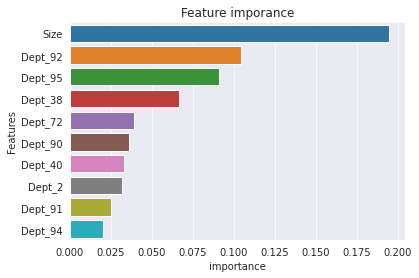

In [65]:
# plot the most important features in model
plt.title('Feature imporance')
sns.barplot(data=importance_df.head(10),x='importance', y='Features');

### Hyperparameter Tuning and Overfitting

In [66]:
base_model = RandomForestRegressor(random_state=42, n_jobs=-1).fit(X_train, train_targets)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [36]:
def Forest_rmse(model,Xtrain,Ytrain,Xval,Yval):
  train_rmse = rmse(model.predict(Xtrain), Ytrain)
  val_rmse = rmse(model.predict(Xval),Yval)
  print("Root mean square error of train set is : ",train_rmse)
  print("Root mean square error of validation set is : ",val_rmse)

In [68]:
Forest_rmse(base_model,X_train,train_targets,X_val,val_targets)

Root mean square of train is :  1433.9252747392688
Root mean square of validation is :  4038.4767414072357


### `n_estimators`

This argument controls the number of decision trees in the random forest. The default value is 100. For larger datasets, it helps to have a greater number of estimators. As a general rule, try to have as few estimators as needed. 


In [69]:
regressor = RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=10)

In [70]:
regressor.fit(X_train, train_targets)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=42)

In [71]:
Forest_rmse(regressor,X_train,train_targets,X_val,val_targets)

Root mean square of train is :  1700.7508187322128
Root mean square of validation is :  4179.328253536355


### `max_depth` and `max_leaf_nodes`

These arguments are passed directly to each decision tree, and control the maximum depth and max. no leaf nodes of each tree respectively. By default, no maximum depth is specified, which is why each tree has a training accuracy of 100%. You can specify a `max_depth` to reduce overfitting.

In [72]:
def test_params(**params):
    modelF = RandomForestRegressor(random_state=42, n_jobs=-1, **params).fit(X_train, train_targets)
    Forest_rmse(modelF,X_train,train_targets,X_val,val_targets)

In [73]:
test_params(max_depth=5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Root mean square of train is :  16473.618090193166
Root mean square of validation is :  16593.15181878335


In [75]:
test_params(max_depth=30)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Root mean square of train is :  5463.069645850578
Root mean square of validation is :  6501.901632771324


In [74]:
test_params(max_leaf_nodes=2**5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Root mean square of train is :  12671.899772083394
Root mean square of validation is :  12946.876954345274


In [76]:
test_params(max_leaf_nodes=2**20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Root mean square of train is :  1431.6984544410686
Root mean square of validation is :  4047.163293116095


### `max_features`

Instead of picking all features (columns) for every split, we can specify that only a fraction of features be chosen randomly to figure out a split.

In [77]:
test_params(max_features='log2')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Root mean square of train is :  2319.7615517564705
Root mean square of validation is :  6260.875054220906


In [79]:
test_params(max_features=3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Root mean square of train is :  3478.9430349357945
Root mean square of validation is :  9303.798616729751


In [78]:
test_params(max_features=6)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Root mean square of train is :  2513.0688805728732
Root mean square of validation is :  6798.991474118677


### `min_samples_split` and `min_samples_leaf`

By default, the decision tree classifier tries to split every node that has 2 or more. You can increase the values of these arguments to change this behavior and reduce overfitting, especially for very large datasets.

In [80]:
test_params(min_samples_split=3, min_samples_leaf=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Root mean square of train is :  2004.2874929534867
Root mean square of validation is :  4236.891007036937


In [ ]:
test_params(min_samples_split=100, min_samples_leaf=60)

### `min_impurity_decrease`

This argument is used to control the threshold for splitting nodes. A node will be split if this split induces a decrease of the impurity (Gini index) greater than or equal to this value. It's default value is 0, and you can increase it to reduce overfitting.


In [81]:
test_params(min_impurity_decrease=1e-7)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Root mean square of train is :  1428.7432929570746
Root mean square of validation is :  4033.641092991631


In [ ]:
test_params(min_impurity_decrease=1e-2)

### `bootstrap`, `max_samples` 

By default, a random forest doesn't use the entire dataset for training each decision tree. Instead it applies a technique called bootstrapping. For each tree, rows from the dataset are picked one by one randomly, with replacement i.e. some rows may not show up at all, while some rows may show up multiple times.


Bootstrapping helps the random forest generalize better, because each decision tree only sees a fraction of th training set, and some rows randomly get higher weightage than others.

In [82]:
test_params(bootstrap=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Root mean square of train is :  3.899016086557794e-11
Root mean square of validation is :  4878.531799514138


### Putting it together

Let's train a random forest with customized hyperparameters based on our learnings. Of course, different hyperpraams

In [37]:
model_RF = RandomForestRegressor(n_jobs=-1, 
                               random_state=42, 
                               n_estimators=300,
                              min_impurity_decrease=1e-7
                              )

In [38]:
model_RF.fit(X_train, train_targets)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(min_impurity_decrease=1e-07, n_estimators=300, n_jobs=-1,
                      random_state=42)

In [39]:
Forest_rmse(model_RF,X_train,train_targets,X_val,val_targets)

Root mean square error of train set is :  1416.725284304636
Root mean square error of validation set is :  4030.353895344298


## Fit the Gradient Boosting

We're now ready to train our gradient boosting machine (GBM) model.

The term "gradient" refers to the fact that each decision tree is trained with the purpose of reducing the loss from the previous iteration (similar to gradient descent). The term "boosting" refers the general technique of training new models to improve the results of an existing model. 



In [40]:
from xgboost import XGBRegressor

In [41]:
model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4)

In [ ]:
%%time
model.fit(X_train,train_targets)

Prediction

We can now make predictions and evaluate the model using `model.predict`.

In [ ]:
preds = model.predict(X_train)

In [ ]:
preds

Evaluation

Let's evaluate the predictions using RMSE error.

In [42]:
from sklearn.metrics import mean_squared_error

def rmse(a, b):
    return mean_squared_error(a, b, squared=False)

In [ ]:
rmse(preds, train_targets)

In [ ]:
rmse(model.predict(X_val),val_targets)

Visualization

We can visualize individual trees using `plot_tree` (note: this requires the `graphviz` library to be installed).

In [43]:
import matplotlib.pyplot as plt
from xgboost import plot_tree
from matplotlib.pylab import rcParams
%matplotlib inline

# rcParams['figure.figsize'] = 25,15

In [ ]:
plot_tree(model, rankdir='LR'); 

In [ ]:
plot_tree(model, rankdir='LR', num_trees=1);

In [ ]:
trees = model.get_booster().get_dump()

In [ ]:
len(trees)

In [ ]:
print(trees[0])

### Feature importance

Just like decision trees and random forests, XGBoost also provides a feature importance score for each column in the input.

In [ ]:
# find the most important features in the model.
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [ ]:
importance_df.head(10)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

### K Fold Cross Validation

Notice that we didn't create a validation set before training our XGBoost model. We'll use a different validation strategy this time, called K-fold cross validation 

In [44]:
from sklearn.model_selection import KFold

In [45]:
# fit the model and return the train and validation error.
def train_and_evaluate(_X_train, _train_targets, X_vald, vald_targets, **params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(_X_train, _train_targets)
    train_rmse = rmse(model.predict(_X_train), _train_targets)
    val_rmse = rmse(model.predict(X_vald), vald_targets)
    return model, train_rmse, val_rmse

In [48]:
kfold = KFold(n_splits=5)

In [49]:
print(train_targets.shape)
print(X_train.shape)

(295099, 1)
(295099, 193)


In [ ]:
# collect the all fitted models in k-fold cross validation and find train and validation errors 
models = []

for train_idxs, val_idxs in kfold.split(X_train):
    _X_train, _train_targets = X_train.iloc[train_idxs], train_targets.iloc[train_idxs]
    X_vald, vald_targets = X_train.iloc[val_idxs], train_targets.iloc[val_idxs]
    model, train_rmse, val_rmse = train_and_evaluate(_X_train, 
                                                     _train_targets, 
                                                     X_vald, 
                                                     vald_targets, 
                                                     max_depth=4, 
                                                     n_estimators=20)
    models.append(model)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

In [46]:
# import numpy as np
# predict the average of the all models
def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

In [ ]:
preds = predict_avg(models, X_train)

In [ ]:
preds

### Hyperparameter Tuning and Regularization

Just like other machine learning models, there are several hyperparameters we can to adjust the capacity of model and reduce overfitting.


In [ ]:
model

In [47]:
def test_params_kfold(n_splits, **params):
    train_rmses, val_rmses, models = [], [], []
    kfold = KFold(n_splits)
    for train_idxs, val_idxs in kfold.split(X_train):
        _X_train, _train_targets = X_train.iloc[train_idxs], train_targets.iloc[train_idxs]
        X_vald, vald_targets = X_train.iloc[val_idxs], train_targets.iloc[val_idxs]
        model, train_rmse, val_rmse = train_and_evaluate(_X_train, _train_targets, X_vald, vald_targets, **params)
        models.append(model)
        train_rmses.append(train_rmse)
        val_rmses.append(val_rmse)
    print('Train RMSE: {}, Validation RMSE: {}'.format(np.mean(train_rmses), np.mean(val_rmses)))
    return models

In [52]:
from sklearn.model_selection import train_test_split

In [53]:
_X_train, X_vald, _train_targets, vald_targets = train_test_split(X_train, train_targets, test_size=0.1)

In [48]:
# check the RMSE with the affect of the new hyperparameter tuning.
def test_params(**params):
    model = XGBRegressor(n_jobs=-1, random_state=42, **params)
    model.fit(_X_train, _train_targets)
    train_rmse = rmse(model.predict(_X_train), _train_targets)
    val_rmse = rmse(model.predict(X_vald), vald_targets)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

 `n_estimators`

The number of trees to be created. More trees = greater capacity of the model.

In [ ]:
test_params(n_estimators=30)

In [ ]:
%%time
test_params(n_estimators=100)

In [ ]:
test_params(n_estimators=300)

In [ ]:
%%time 
test_params(n_estimator=400)

 `max_depth`

As you increase the max depth of each tree, the capacity of the tree increases and it can capture more information about the training set.

In [ ]:
test_params(max_depth=2)

In [ ]:
test_params(max_depth=5)

In [ ]:
test_params(n_estimator = 300,max_depth=5)

In [ ]:
test_params(max_depth=10)

`learning_rate`

The scaling factor to be applied to the prediction of each tree. A very high learning rate (close to 1) will lead to overfitting, and a low learning rate (close to 0) will lead to underfitting.

In [ ]:
test_params(n_estimators=50, learning_rate=0.01)

In [ ]:
test_params(n_estimators=50, learning_rate=0.2)

In [ ]:
test_params(n_estimators=50, learning_rate=0.3)

### Putting it Together and Making Predictions

Let's train a final model on the entire training set with custom hyperparameters. 

In [56]:
model_GB = XGBRegressor(n_jobs=-1, random_state=42, n_estimators=300, 
                     learning_rate=0.3, max_depth=10)

In [57]:
%%time
model_GB.fit(X_train, train_targets)

[17:23:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 30min 6s, sys: 3.6 s, total: 30min 10s
Wall time: 15min 31s


XGBRegressor(learning_rate=0.3, max_depth=10, n_estimators=300, n_jobs=-1,
             random_state=42)

In [58]:
val_preds = model_GB.predict(X_val)

In [59]:
rmse(val_preds,val_targets)

3435.6795786735574

In [63]:
X_train.shape

(295099, 193)

## Final selection model and prediction 


After the Hyperperametric tuning, rmse(gredient boosting) is less then rmse(Randon Forest). so we use Gradient Boosting to furthere prediction. 

In Gradient boosting, 3435.679 is the validation error.


In Random forest, 4030.353 is the validation error.


then we choose Gradient boosting to further modeling.



Prepare the Test Data for making prediction

In [65]:
# Preparing the test data.

# select the input and target column 
input_cols = ['Store', 'Dept', 'IsHoliday', 'Type', 'Size','Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3','MarkDown4', 'MarkDown5', 'CPI', 'Unemployment','Week']
target_cols = ['Weekly_Sales']
test_inputs = test_df[input_cols].copy()


# Here we manually select the numeric and categorical columns
numeric_cols =  ['Size','Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3','MarkDown4', 'MarkDown5', 'CPI', 'Unemployment']
categorical_cols =  ['Store', 'Dept', 'IsHoliday', 'Type','Week'] 

# Scaling the Numeric columns 
scaler = MinMaxScaler()
scaler.fit(test_df[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])


# encoding the categorical columns 
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoder.fit(train_df[categorical_cols])
encoded_cols = list(encoder.get_feature_names(categorical_cols))

test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

# Data for model building 
X_test = test_inputs[numeric_cols + encoded_cols]



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


In [66]:
X_test.shape

(115064, 193)

In [67]:
len(encoded_cols)

183

### Prediction for Test Data

In [68]:
# Predict the values for Test data
test_preds = model_GB.predict(X_test)

Add the prediction columns into test dataset

In [70]:
test_df['Weekly_sales'] = test_preds

In [73]:
test_df.head(10)

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,month,Day,Week,Weekly_sales
0,1,1,2012-11-02,0,A,151315,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,2012,11,2,44,40041.492188
1,1,1,2012-11-09,0,A,151315,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,2012,11,9,45,17590.941406
2,1,1,2012-11-16,0,A,151315,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,2012,11,16,46,20440.251953
3,1,1,2012-11-23,1,A,151315,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,2012,11,23,47,21848.386719
4,1,1,2012-11-30,0,A,151315,52.34,3.207,2460.03,0.00,3838.35,150.57,6966.34,223.610984,6.573,2012,11,30,48,29038.939453
5,1,1,2012-12-07,0,A,151315,64.12,3.198,6343.16,0.00,270.00,2928.90,10147.90,223.660021,6.573,2012,12,7,49,24997.136719
6,1,1,2012-12-14,0,A,151315,48.89,3.168,3504.83,0.00,73.26,1636.80,2779.60,223.719277,6.573,2012,12,14,50,45132.441406
7,1,1,2012-12-21,0,A,151315,56.02,3.098,8231.71,0.00,274.00,358.15,2834.02,223.839845,6.573,2012,12,21,51,47507.546875
8,1,1,2012-12-28,1,A,151315,44.79,3.108,12659.55,37101.13,174.78,74.46,1208.86,223.960414,6.573,2012,12,28,52,21342.753906
9,1,1,2013-01-04,0,A,151315,41.73,3.161,1214.08,25366.33,15.01,72.36,3940.02,224.080983,6.525,2013,1,4,1,15447.126953


Add the predicted value into sample_submission file

In [74]:
sample_submission['Weekly_sales']  = test_preds

In [81]:
sample_submission.head()

,Id,Weekly_Sales,Weekly_sales
0,1_1_2012-11-02,0,40041.492188
1,1_1_2012-11-09,0,17590.941406
2,1_1_2012-11-16,0,20440.251953
3,1_1_2012-11-23,0,21848.386719
4,1_1_2012-11-30,0,29038.939453


This `sample_submission` file is ready to submit in competation in kaggle. 

## Saving and Loading Trained Models

We can save the parameters (weights and biases) of our trained model to disk, so that we needn't retrain the model from scratch each time we wish to use it. Along with the model, it's also important to save imputers, scalers, encoders and even column names. Anything that will be required while generating predictions using the model should be saved.

We can use the `joblib` module to save and load Python objects on the disk. 

In [83]:
import joblib

In [84]:
walmart_prediction = {
    'model': model_GB,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_cols': target_cols,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

In [85]:
joblib.dump(walmart_prediction, 'walmart_prediction.joblib')

['walmart_prediction.joblib']

The object can be loaded back using `joblib.load`

In [86]:
walmart_prediction2 = joblib.load('walmart_prediction.joblib')

[18:16:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [87]:
test_preds2 = walmart_prediction2['model'].predict(X_test)


## Summary and References
In this notebook, we use these topics
- Download the dataset from Kaggle Competition.
- Perform Exploratory Analysis.
- Performing feature engineering and prepare the dataset for training.
- Training and interpreting a Random Forest model and tuning hyperparameter.
- Training and interpreting a Gradient boosting model using XGBoost and tuning hyperparameters.


For creating this notebook i take a reference of 
- Jovian Course: Machine Learning with Python: Zero to GBMs.
- kaggle most voted notebooks of walmart_sales_Prediction competition.


In [50]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.
